# Gillespy2 interface

In this notebook, we demonstrate use of Gillespy2 on the example of an epidemiological SIR model. The analysis performed is the same as in [this](https://pyabc.readthedocs.io/en/latest/examples/using_julia.html) notebook. 

In [1]:
!pip install gillespy2 --quiet
import gillespy2
import numpy as np
import matplotlib.pyplot as plt
import tempfile

import pyabc
from pyabc import ABCSMC, RV, Distribution

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

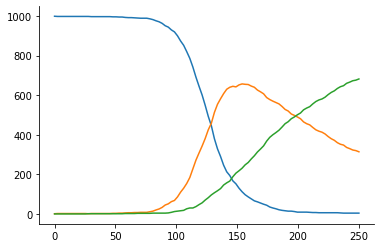

In [2]:
def sir_model(p):
    k1_val, k2_val = 10.0**np.array([p["p1"], p["p2"]])
    # First call the gillespy2.Model initializer.
    model = gillespy2.Model(name="SIR")

    # Define parameters.
    k1 = gillespy2.Parameter(name='k1', expression=k1_val)
    k2 = gillespy2.Parameter(name='k2', expression=k2_val)
    model.add_parameter([k1, k2])

    # Define species.
    S = gillespy2.Species(name='S', initial_value=999)
    I = gillespy2.Species(name='I', initial_value=1)
    R = gillespy2.Species(name='R', initial_value=0)
    model.add_species([S, I, R])

    # Define reactions.
    r1 = gillespy2.Reaction(
        name="r1", rate=k1, reactants={S: 1, I: 1}, products={I: 2}
    )

    r2 = gillespy2.Reaction(
        name="r2", rate=k2, reactants={I: 1}, products={R: 1}
    )

    model.add_reaction([r1, r2])

    # Set the timespan for the simulation.
    tspan = gillespy2.TimeSpan.linspace(250, 100)
    model.timespan(tspan)
    
    return model.run()[0]

p_true = {"p1": -4, "p2": -2}
y_obs = sir_model(p_true)

plt.plot(y_obs["time"], np.array([y_obs["S"], y_obs["I"], y_obs["R"]]).T);

In [3]:
def distance(y, y_obs):
    y = np.array([y["S"], y["I"], y["R"]])
    y_obs = np.array([y_obs["S"], y_obs["I"], y_obs["R"]])
    return ((y - y_obs)**2).sum()

In [4]:
gt_par = {"p1": -4.0, "p2": -2.0}

# parameter limits and prior
par_limits = {
    "p1": (-5, -3),
    "p2": (-3, -1),
}
prior = Distribution(
    **{key: RV("uniform", lb, ub - lb) for key, (lb, ub) in par_limits.items()}
)

In [5]:
%%time

abc = ABCSMC(
    sir_model,
    prior,
    distance,
    population_size=20,
)
db = tempfile.mkstemp(suffix=".db")[1]
abc.new("sqlite:///" + db, y_obs)
h = abc.run(max_nr_populations=5)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
2022-08-25 23:55:46,566 - ABC.Sampler - INFO - Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2022-08-25 23:55:46>
2022-08-25 23:55:46,729 - ABC.History - INFO - Start <ABCSMC id=1, start_time=2022-08-25 23:55:46>
ABC INFO: Calibration sample t = -1.
2022-08-25 23:55:46,753 - ABC - INFO - Calibration sample t = -1.
ABC INFO: t: 0, eps: 6.42937210e+07.
2022-08-25 23:56:23,709 - ABC - INFO - t: 0, eps: 6.42937210e+07.
ABC INFO: Accepted: 20 / 57 = 3.5088e-01, ESS: 2.0000e+01.
2022-08-25 23:57:49,528 - ABC - INFO - Accepted: 20 / 57 = 3.5088e-01, ESS: 2.0000e+01.
ABC INFO: t: 1, eps: 4.58767410e+07.
2022-08-25 23:57:49,611 - ABC - INFO - t: 1, eps: 4.58767410e+07.
ABC INFO: Accepted: 20 / 58 = 3.4483e-01, ESS: 1.8302e+01.
2022-08-25 23:59:07,747 - ABC - INFO - Accepted: 20 / 58 = 3.4483e-01, ESS: 1.8302e+01.
ABC INFO: t: 2, eps: 2.66978797e+07.
2022-08-25 23:59:07,829 - ABC - INFO - t: 2, eps: 2.

CPU times: user 1.34 s, sys: 591 ms, total: 1.93 s
Wall time: 8min 7s


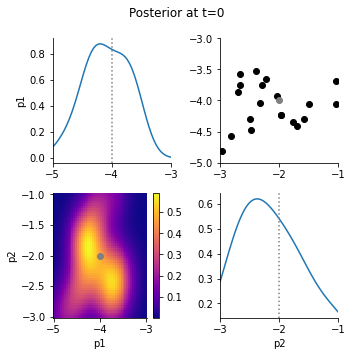

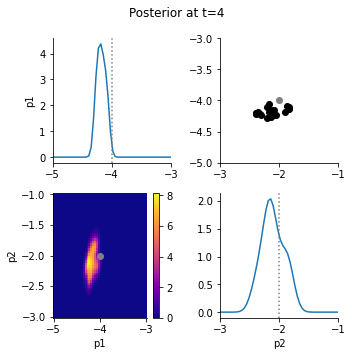

In [6]:
for t in [0, h.max_t]:
    pyabc.visualization.plot_kde_matrix_highlevel(
        h,
        t=t,
        limits=par_limits,
        refval=gt_par,
        refval_color="grey",
    )
    plt.gcf().suptitle(f"Posterior at t={t}")
    plt.gcf().tight_layout();

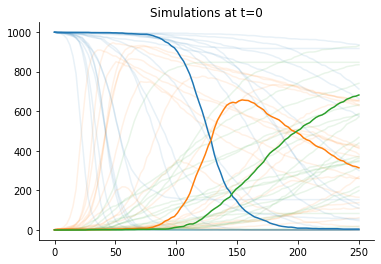

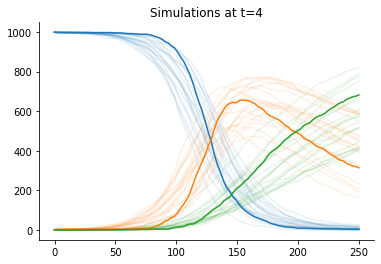

In [7]:
def plot_data(sumstat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    for i, var in enumerate(["S", "I", "R"]):
        ax.plot(sumstat["time"], sumstat[var], color=f"C{i}", alpha=0.1)


for t in [0, h.max_t]:
    _, ax = plt.subplots()
    pyabc.visualization.plot_data_callback(
        h,
        plot_data,
        t=t,
        ax=ax,
    )
    for i, var in enumerate(["S", "I", "R"]):
        ax.plot(y_obs["time"], y_obs[var], color=f"C{i}")
    ax.set_title(f"Simulations at t={t}");